# TreeCorr Tutorial
This tutorial is intended to give you a rough overview of TreeCorr functionality.  It doesn't cover every feature by a long shot, but it should hopefully give you enough of a flavor of how TreeCorr works to be able to find more information in the full [TreeCorr documentation](http://rmjarvis.github.io/TreeCorr/html/index.html)

---

This script lives in the [TreeCorr/tests](https://github.com/rmjarvis/TreeCorr/tree/main/tests) directory, and should run successfully if executed from there.  The [Aardvark.fit](https://github.com/rmjarvis/TreeCorr/wiki/Aardvark.fit) file we use here will be automatically downloaded by the test suite, so if you run nosetests in that directory, it should be downloaded for you.

In [1]:
# First some imports that we'll use below
from __future__ import print_function
import treecorr
import fitsio
import numpy
import time
import pprint
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  

For this demo, we'll use input data from a cosmological simulation for DES, called Aardvark, of which the [Aardvark.fit](https://github.com/rmjarvis/TreeCorr/wiki/Aardvark.fit) file we are using is just a subset.
First, let's take a look at what's in that file.

In [2]:
file_name = 'data/Aardvark.fit'
data = fitsio.read(file_name)
print(data.dtype)  # Includes ra, dec, redshift, and lensing observables
print(data.shape)  # 390K objects

[('INDEX', '>i4'), ('RA', '>f4'), ('DEC', '>f4'), ('Z', '>f4'), ('EPSILON', '>f4', (2,)), ('GAMMA1', '>f4'), ('GAMMA2', '>f4'), ('KAPPA', '>f4'), ('MU', '>f4')]
(390935,)


### Using a configuration file

There are two modes for running treecorr.  You can either write a config file that specifies
the nature of the data and what you want TreeCorr to calculate.  Or you can do each step
yourself within python. We'll start with the first mode by running a config file that will
compute a shear-shear correlation function on these data.  This [config file](https://github.com/rmjarvis/TreeCorr/blob/main/tests/Aardvark.yaml) is located in 
the [treecorr/tests](https://github.com/rmjarvis/TreeCorr/tree/main/tests) directory.

In [3]:
config_file = 'Aardvark.yaml'
with open(config_file) as fin:
    print(''.join(fin.readlines()))


# The file with the data to be correlated:
# (available from https://github.com/rmjarvis/TreeCorr/wiki/Aardvark.fit)
file_name: data/Aardvark.fit

# What are the names of the columns for ra, dec and what kind of values do they have:
ra_col: RA          # The column name for RA values in the input file
dec_col: DEC        # The column name for Dec values in the input file
ra_units: degrees   # The units of the RA values
dec_units: degrees  # The units of the Dec values

# What are the names of the columns for the lensing observables to be correlated
g1_col: GAMMA1      # The column name of the g1 component of shear
g2_col: GAMMA2      # The column name of the g2 component of shear
k_col: KAPPA        # The column name of kappa
                    # Note: k_col can be used for any scalar field, not just lensing kappa.

# Define the binning.  Binning in TreeCorr uses bins that are equally spaced in log(r).
# (i.e. Natural log, not log10.)  There are four parameters of which you may speci

The corr2 executable installed when you install treecorr will use this config file to process the data and output the correlation to an ASCII file (output/Aardvark.out). From the shell prompt, you would run:
```
$ corr2 Aardvark.yaml
```
The same thing can be done from within python, so we'll do it that way here.  It is a two step process:

First we need to read the config file in a python dict.  There is a treecorr utility function to do this called `treecorr.read_config`. In this case, since the config file is a yaml file, it is equivalent to doing `yaml.load(open(config_file))`.

In [4]:
config = treecorr.read_config(config_file)
print(pprint.pformat(config))

{'dec_col': 'DEC',
 'dec_units': 'degrees',
 'file_name': 'data/Aardvark.fit',
 'g1_col': 'GAMMA1',
 'g2_col': 'GAMMA2',
 'gg_file_name': 'output/Aardvark.out',
 'k_col': 'KAPPA',
 'max_sep': 400,
 'min_sep': 1,
 'nbins': 100,
 'ra_col': 'RA',
 'ra_units': 'degrees',
 'sep_units': 'arcmin',
 'verbose': 2}


And then the treecorr function `corr2` takes this dict as a parameter

In [5]:
treecorr.corr2(config)

Using 4 threads.
   file_type assumed to be FITS from the file name.
Done creating input catalogs
Performing GG calculations...
nbins = 100, min,max sep = 1..400 arcmin, bin_size = 0.0599146
Starting process GG auto-correlations for cat data/Aardvark.fit.
Reading input file data/Aardvark.fit
   nobj = 390935
Using 4 threads.
Building GField from cat data/Aardvark.fit
Starting 259 jobs.
varg = 0.000006: sig_sn (per component) = 0.002456
Done GG calculations.
Writing GG correlations to output/Aardvark.out
   file_type assumed to be ASCII from the file name.
Wrote GG correlation to output/Aardvark.out


The output file has a number of columns:

- R_nom is the nominal center of each bin (exp(logr) where logr is spaced uniformly)
- meanR is the actual measured mean of the pairs that went into that bin
- meanlogR is the measured mean log(R) of the pairs
- xip is the computed xi+(R)
- xim is the computed xi-(R)
- xip_im, xim_im are the imaginary components of these, since they are technically complex valued
- sigma_xi is an estimated error bar for both xip and xim from the shape noise
- weight is the total weight of the pairs: sum(w1 w2) if the catalog entries were given weights.
- npairs is the total number of pairs in each bin.

**IMPORTANT**:
The sigma_xi estimate only includes shot noise.  It does not (and cannot) include sample variance,
which is almost always an important component of the total uncertainty of these 
values.  Furthermore, the measured xi values are correlated, so the covariance 
matrix is not diagonal.
Therefore, in general, you would want to use something like jackknife to get a better
estimate of the covariance matrix of these points.  sigma_xi is just a very rough 
(under-)estimate to help guide the eye in plots.

In [6]:
with open('output/Aardvark.out') as f:
    print(''.join(f.readlines()[:10]))   # Just the first 10 lines for brevity

## {'coords': 'spherical', 'metric': 'Euclidean', 'sep_units': 'arcmin', 'bin_type': 'Log'}
#   r_nom       meanr       meanlogr       xip          xim         xip_im       xim_im     sigma_xip    sigma_xim      weight       npairs   
  1.0304e+00   1.0311e+00   3.0480e-02   7.5773e-06   1.6730e-07   7.0288e-08  -3.5156e-08   1.8992e-08   1.8992e-08   2.0181e+05   2.0181e+05
  1.0940e+00   1.0948e+00   9.0389e-02   7.3854e-06   3.5900e-07  -2.0456e-08   1.5109e-08   1.7948e-08   1.7948e-08   2.2597e+05   2.2597e+05
  1.1616e+00   1.1623e+00   1.5029e-01   7.1456e-06   2.6500e-07  -1.3585e-08  -5.0992e-08   1.6930e-08   1.6930e-08   2.5396e+05   2.5396e+05
  1.2333e+00   1.2342e+00   2.1029e-01   7.0705e-06   2.1739e-07  -4.6803e-08  -8.8672e-08   1.6049e-08   1.6049e-08   2.8261e+05   2.8261e+05
  1.3095e+00   1.3104e+00   2.7017e-01   6.8516e-06   3.4166e-07   6.9887e-08  -8.9427e-08   1.5142e-08   1.5142e-08   3.1746e+05   3.1746e+05
  1.3903e+00   1.3914e+00   3.3014e-01   6.6381e-0

---
### Reading in an input Catalog
Now let's repeat that process within Python. 
The first step is to read in the input data into a treecorr.Catalog object.

For reference, this corresponds to these lines in the config file:
```
file_name: data/Aardvark.fit

ra_col: RA
dec_col: DEC
ra_units: degrees
dec_units: degrees

g1_col: GAMMA1
g2_col: GAMMA2
k_col: KAPPA
```

In [7]:
cat = treecorr.Catalog(file_name, ra_col='RA', dec_col='DEC', ra_units='deg', dec_units='deg', g1_col='GAMMA1', 
                       g2_col='GAMMA2', k_col='KAPPA')

### Computing a shear-shear correlation function
Next we need to define what kind of correlation function we want to build including how we want the binning to work, which in the config file corresponds to these lines:
```
min_sep: 1
max_sep: 400
nbins: 100
sep_units: arcmin
```

In [8]:
gg = treecorr.GGCorrelation(min_sep=1, max_sep=400, nbins=100, sep_units='arcmin')

I recommend usually using `bin size <= 0.1`.  If you use fatter bins than this, then internally
TreeCorr will set [bin_slop](http://rmjarvis.github.io/TreeCorr/html/correlation2.html#treecorr.BinnedCorr2)) such that `bin_slop * bin_size = 0.1` to avoid various numerical problems that show up with fat bins.

In this case, `bin_size` is inferred from `min_sep`, `max_sep`, `nbins`, and comes out to ~0.06.

In [9]:
print('bin_size = %.6f'%gg.bin_size)

bin_size = 0.059915


Now the actual calculation is done with the GGCorrelation.process method. 

As a rule of thumb, this takes around 1 minute per million objects (for typical kinds of binning choices). 

Using smaller bins or bin_slop < 1 will be slower.  Fatter bins will be faster.  Also, count-count correlations (which we'll get to later) are faster, since there is less work to do for each pair.

In [10]:
t1 = time.time()
gg.process(cat)  # Takes approx 1 minute / million objects
t2 = time.time()
print('Time for calculating gg correlation = ',t2-t1)

Time for calculating gg correlation =  10.750648975372314


Rather than write to disk, we can now access the correlation function directly.  In most 
cases, the correlation function is called xi.  For gg, there are two: xi+ and xi-, which 
are named xip and xim in TreeCorr. 
These are numpy arrays that you could plot or send on to some likelihood calculation, etc.

Note: The error bars here are significantly underestimated, since they only include
      shape noise, not sample variance, which is a significant contributor to the total
      variance. The sample variance (and indeed the full covariance matrix) is typically
      estimated either from the data via jackknife or similar technique, or fromtheory/simulations.


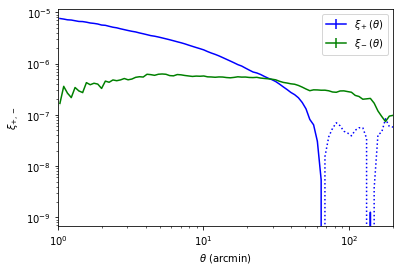

In [11]:
r = numpy.exp(gg.meanlogr)
xip = gg.xip
xim = gg.xim
sig = numpy.sqrt(gg.varxip)

plt.plot(r, xip, color='blue')
plt.plot(r, -xip, color='blue', ls=':')
plt.errorbar(r[xip>0], xip[xip>0], yerr=sig[xip>0], color='blue', lw=0.1, ls='')
plt.errorbar(r[xip<0], -xip[xip<0], yerr=sig[xip<0], color='blue', lw=0.1, ls='')
lp = plt.errorbar(-r, xip, yerr=sig, color='blue')

plt.plot(r, xim, color='green')
plt.plot(r, -xim, color='green', ls=':')
plt.errorbar(r[xim>0], xim[xim>0], yerr=sig[xim>0], color='green', lw=0.1, ls='')
plt.errorbar(r[xim<0], -xim[xim<0], yerr=sig[xim<0], color='green', lw=0.1, ls='')
lm = plt.errorbar(-r, xim, yerr=sig, color='green')

plt.xscale('log')
plt.yscale('log', nonpositive='clip')
plt.xlabel(r'$\theta$ (arcmin)')

plt.legend([lp, lm], [r'$\xi_+(\theta)$', r'$\xi_-(\theta)$'])
plt.xlim( [1,200] )
plt.ylabel(r'$\xi_{+,-}$')
plt.show()

### Computing a count-count correlation function
Next let's calculate the regular count-count correlation function.

The letter TreeCorr uses for galaxy counts is N, so the count-count correlation function 
is called NNCorrelation in TreeCorr.  
In this case, we will also need a random catalog, which we'll get to below, but for now we 
can calculate the data auto-correlation, which is traditionally called dd for data-data.

In [12]:
dd = treecorr.NNCorrelation(min_sep=0.01, max_sep=10, bin_size=0.2, sep_units='degrees')
dd.process(cat)

Now we have to make a random catalog.  For real data (not a simulation), this would typically involve a sophisticated treatment of the mask, the variation in the survey depth, etc.  It's normally a rather complicated calculation.  But for simulated data, as we have here, we can just randomly place points within the ra, dec range in the catalog.

Note: for points to be uniformly distributed on the sky (which is what the random catalog should be), the positions should have uniform distributions in RA and sin(Dec).  Not uniform in Dec.

In [13]:
ra_min = numpy.min(cat.ra)
ra_max = numpy.max(cat.ra)
dec_min = numpy.min(cat.dec)
dec_max = numpy.max(cat.dec)
print('ra range = %f .. %f' % (ra_min, ra_max))
print('dec range = %f .. %f' % (dec_min, dec_max))

rand_ra = numpy.random.uniform(ra_min, ra_max, 10**6)
rand_sindec = numpy.random.uniform(numpy.sin(dec_min), numpy.sin(dec_max), 10**6)
rand_dec = numpy.arcsin(rand_sindec)

ra range = 0.000057 .. 1.570791
dec range = 1.366483 .. 1.570051


In this case, our catalog has a weird shape, which is moderately well approximated by the following mask.  Close enough for the purpose of this demo, but for real science work, you should be more careful than this, since it doesn't get the curved edge exactly right.


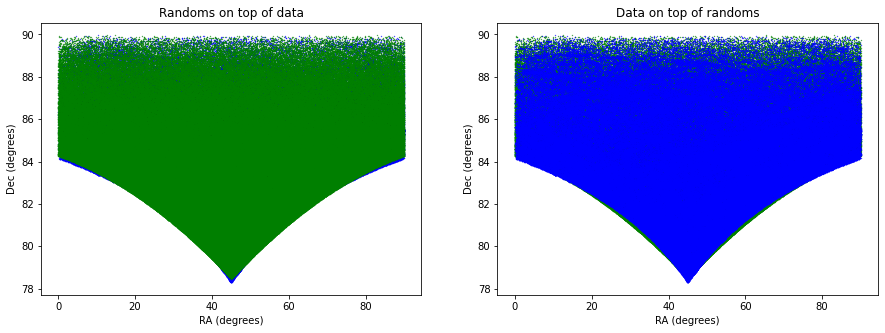

In [14]:
rand_ra_pi = rand_ra / numpy.pi
rand_cosdec = numpy.cos(rand_dec)
mask = ( (rand_cosdec < 0.1*(1 + 2*rand_ra_pi + 8*(rand_ra_pi)**2)) &
         (rand_cosdec < 0.1*(1 + 2*(0.5-rand_ra_pi) + 8*(0.5-rand_ra_pi)**2)) )
rand_ra = rand_ra[mask]
rand_dec = rand_dec[mask]

# Check that the randoms cover the same space as the data
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
ax1.scatter(cat.ra * 180/numpy.pi, cat.dec * 180/numpy.pi, color='blue', s=0.1)
ax1.scatter(rand_ra * 180/numpy.pi, rand_dec * 180/numpy.pi, color='green', s=0.1)
ax1.set_xlabel('RA (degrees)')
ax1.set_ylabel('Dec (degrees)')
ax1.set_title('Randoms on top of data')

# Repeat in the opposite order
ax2.scatter(rand_ra * 180/numpy.pi, rand_dec * 180/numpy.pi, color='green', s=0.1)
ax2.scatter(cat.ra * 180/numpy.pi, cat.dec * 180/numpy.pi, color='blue', s=0.1)
ax2.set_xlabel('RA (degrees)')
ax2.set_ylabel('Dec (degrees)')
ax2.set_title('Data on top of randoms')

plt.show()

It's also fun to blow up a portion of this to see the clustering in the data.
Note: the cos(dec) factor makes the ra values real angles on the sky (locally), so the points are not stretched out along the RA direction due to Mercator projection.

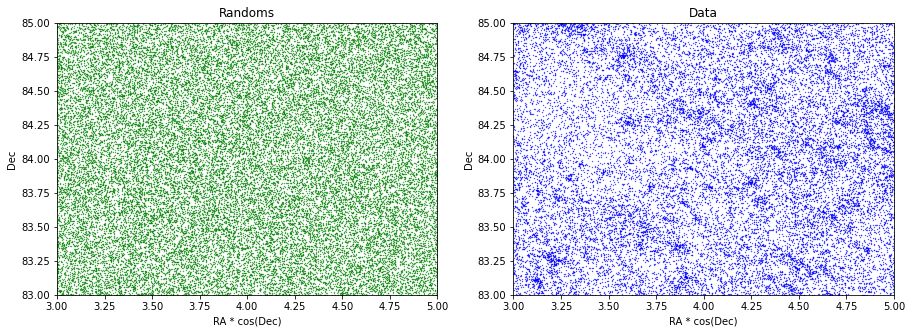

In [15]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
ax1.scatter(rand_ra * 180/numpy.pi * numpy.cos(rand_dec), rand_dec * 180/numpy.pi, color='green', s=0.1)
ax1.set_xlabel('RA * cos(Dec)')
ax1.set_ylabel('Dec')
ax1.set_xlim(3,5)
ax1.set_ylim(83,85)
ax1.set_title('Randoms')

ax2.scatter(cat.ra * 180/numpy.pi * numpy.cos(cat.dec), cat.dec * 180/numpy.pi, color='blue', s=0.1)
ax2.set_xlabel('RA * cos(Dec)')
ax2.set_ylabel('Dec')
ax2.set_xlim(3,5)
ax2.set_ylim(83,85)
ax2.set_title('Data')

plt.show()

Now we can make the Catalog for the randoms.  Rather than use a file on disk, here we will
build the Catalog from the existing numpy arrays that we just made.  Also, the NNCorrelation 
doesn't need g1, g2, or kappa values, so we don't bother to give anything for them.

We also need to make a second NNCorrelation object to do the same processing on the randoms that we did on the data.

In [16]:
rand = treecorr.Catalog(ra=rand_ra, dec=rand_dec, ra_units='radians', dec_units='radians')
rr = treecorr.NNCorrelation(min_sep=0.01, max_sep=10, bin_size=0.2, sep_units='degrees')
rr.process(rand)

Then the simple estimate of the correlation function xi = (dd-rr)/rr is calculated via the function dd.calculateXi(rr).  (We'll get to the more accurate Landy-Szalay formula below.)


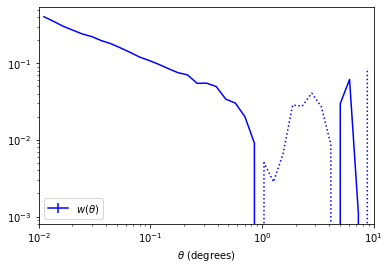

In [17]:
xi, varxi = dd.calculateXi(rr)

r = numpy.exp(dd.meanlogr)
sig = numpy.sqrt(varxi)

plt.plot(r, xi, color='blue')
plt.plot(r, -xi, color='blue', ls=':')
plt.errorbar(r[xi>0], xi[xi>0], yerr=sig[xi>0], color='blue', lw=0.1, ls='')
plt.errorbar(r[xi<0], -xi[xi<0], yerr=sig[xi<0], color='blue', lw=0.1, ls='')
leg = plt.errorbar(-r, xi, yerr=sig, color='blue')

plt.xscale('log')
plt.yscale('log', nonpositive='clip')
plt.xlabel(r'$\theta$ (degrees)')

plt.legend([leg], [r'$w(\theta)$'], loc='lower left')
plt.xlim([0.01,10])
plt.show()

A better estimator for the correlation function is the Landy-Szalay formula (dd-2dr+rr)/rr.
For this we need a cross-correlation between the data and the randoms.
This is also done with the process function, but now with two arguments.

In [18]:
dr = treecorr.NNCorrelation(min_sep=0.01, max_sep=10, bin_size=0.2, sep_units='degrees')
dr.process(cat, rand)

If you pass both rr and dr to calculateXi, then it will use the Landy-Szalay formula, which is more accurate than the simple formula used above.  Note that both curves roughly follow a power law as expected at small scales, but the Landy-Szalay formula recovers the power law out to somewhat higher separations than the simple formula.  

Also, similar to what we saw with the GG correlation function, the error bars are clearly underestimated, since they only include shot noise, not sample variance.

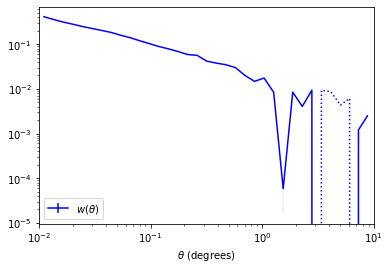

In [19]:
xi, varxi = dd.calculateXi(rr, dr)
sig = numpy.sqrt(varxi)

plt.plot(r, xi, color='blue')
plt.plot(r, -xi, color='blue', ls=':')
plt.errorbar(r[xi>0], xi[xi>0], yerr=sig[xi>0], color='blue', lw=0.1, ls='')
plt.errorbar(r[xi<0], -xi[xi<0], yerr=sig[xi<0], color='blue', lw=0.1, ls='')
leg = plt.errorbar(-r, xi, yerr=sig, color='blue')

plt.xscale('log')
plt.yscale('log', nonpositive='clip')
plt.xlabel(r'$\theta$ (degrees)')

plt.legend([leg], [r'$w(\theta)$'], loc='lower left')
plt.xlim([0.01,10])
plt.show()

---
### Links for further reading

- The [2004 paper](http://adsabs.harvard.edu/abs/2004MNRAS.352..338J) that describes the basic algorithm implemented in TreeCorr (section 4.1).

- An annotated [sample configuration file](https://github.com/rmjarvis/TreeCorr/blob/main/sample_config.yaml), which shows, among many other things, how to specify multiple input files, including randoms, in a configuration file.

- Full documentation of all [allowed configuration parameters](https://github.com/rmjarvis/TreeCorr/wiki/Configuration-Parameters).

- All the possible parameters for a [Catalog object](http://rmjarvis.github.io/TreeCorr/html/catalog.html), including things like flip_g1/flip_g2 to
adjust shear definition conventions, how to specify weights, how to skip objects with
particular (e.g. non-zero) flags, and more.

- Documentation about the different [Metric](http://rmjarvis.github.io/TreeCorr/html/metric.html) options that are possible in TreeCorr including Rlens, which uses the perpendicular distance at the location of the first object (typically a lens) and Rperp which is approximately the perpendicular separation a the geometric mean distance to the two objects in a pair.